In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define the path relative to the notebook location
processed_data_path = 'E:/GUVI/Projects/customer_conversion_analysis/data_processed/train_cleaned.csv'


# Load the cleaned data
try:
    df_train = pd.read_csv(processed_data_path)
    print("Cleaned training data loaded successfully.")
    print(f"Shape: {df_train.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {processed_data_path}")
    print("Make sure you have run the preprocessing notebook (1_data_preprocessing.ipynb) first.")
    # Stop execution or handle error appropriately
    raise

# Display basic info to confirm loading
print("\n--- Data Head ---")
print(df_train.head())

print("\n--- Data Info ---")
df_train.info()

print("\n--- Numerical Summary ---")
print(df_train.describe())

# Note: Since encoding was done, describe(include='object') might be empty
# unless some object columns were intentionally kept (unlikely after get_dummies)
print("\n--- Categorical Summary (Post-Encoding Check) ---")
print(df_train.describe(include=['object', 'bool'])) # Check for boolean like Weekend too

Cleaned training data loaded successfully.
Shape: (132379, 14)

--- Data Head ---
   year  month  day  order  country  session_id  page_1_main_category  \
0  2008      6   22     21       29       15648                     3   
1  2008      5   19      6       29       10018                     2   
2  2008      7   15      2       29       19388                     3   
3  2008      5    2      2       29        7181                     2   
4  2008      6    9     16       29       13493                     2   

  page_2_clothing_model  colour  location  model_photography  price  price_2  \
0                   C20      13         1                  2   48.0        1   
1                   B26      13         3                  1   57.0        1   
2                   C13       9         5                  1   48.0        1   
3                   B11       2         4                  1   43.0        2   
4                   B31       9         5                  1   57.0        1   

--- Initial EDA on Clickstream Data ---


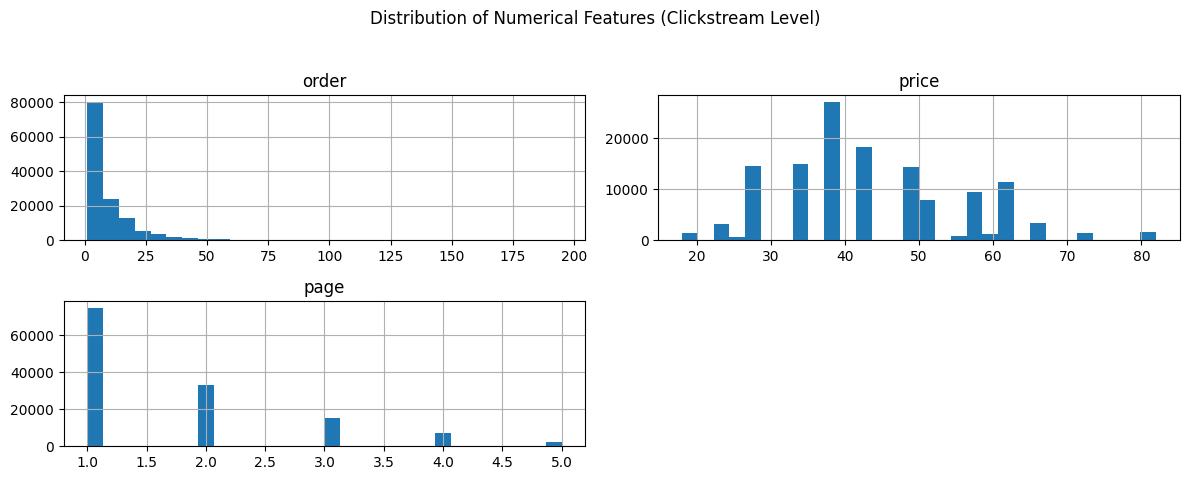

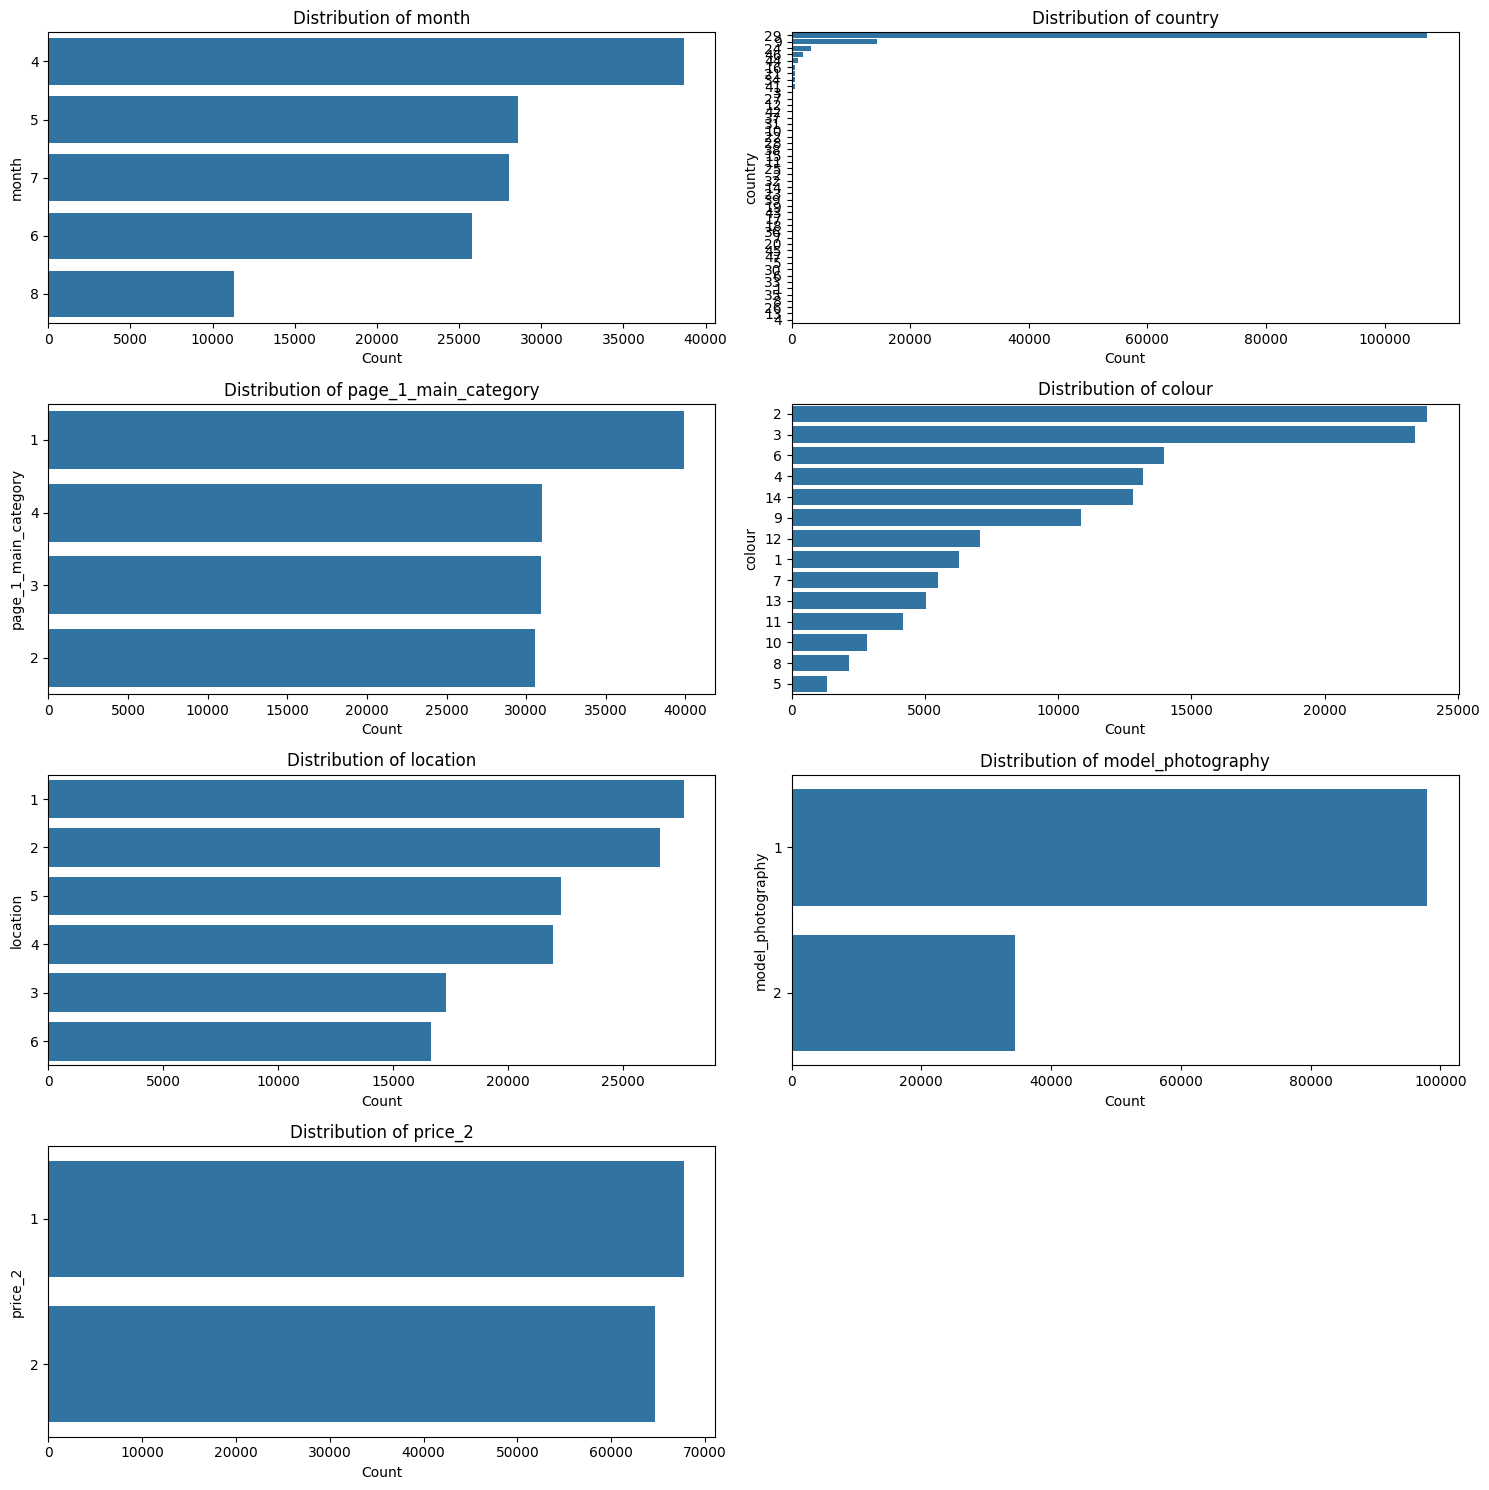


Number of unique clothing models (page_2_clothing_model): 216


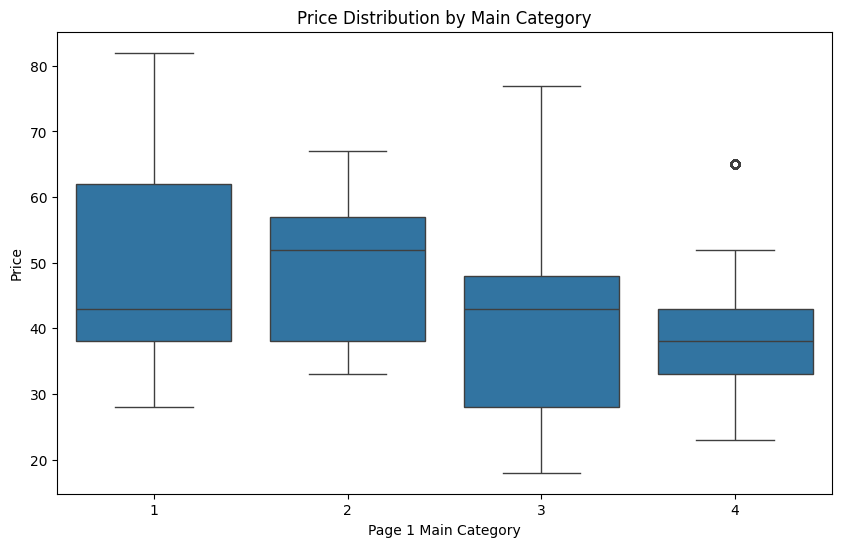

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Make sure df_train is loaded correctly from step 1 ---

print("--- Initial EDA on Clickstream Data ---")

# Distribution of numerical features (unscaled)
numerical_features = ['order', 'price', 'page']
df_train[numerical_features].hist(figsize=(12, 5), bins=30)
plt.suptitle('Distribution of Numerical Features (Clickstream Level)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

# Count plots for key categorical features
categorical_features = ['month', 'country', 'page_1_main_category', 'colour', 'location', 'model_photography', 'price_2']
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_features):
    plt.subplot(4, 2, i + 1)
    sns.countplot(y=col, data=df_train, order=df_train[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col) # Use y-axis for better readability with many categories (like country)
plt.tight_layout()
plt.show()

# How many unique clothing models?
print(f"\nNumber of unique clothing models (page_2_clothing_model): {df_train['page_2_clothing_model'].nunique()}")

# Relationship between page category and price
plt.figure(figsize=(10, 6))
sns.boxplot(x='page_1_main_category', y='price', data=df_train)
plt.title('Price Distribution by Main Category')
plt.xlabel('Page 1 Main Category')
plt.ylabel('Price')
plt.show()

In [16]:
print("\n--- Aggregating Data to Session Level ---")

# Define aggregation functions
aggregation_functions = {
    'order': 'max',
    'page_1_main_category': ['nunique', lambda x: x.mode()[0] if not x.mode().empty else None],
    'page_2_clothing_model': 'nunique',
    'colour': ['nunique', lambda x: x.mode()[0] if not x.mode().empty else None],
    'price': ['mean', 'sum', 'max'],
    'page': ['max', 'count'],
    # ====> CHECK THESE LINES <====
    'month': 'first',
    'day': 'first',
    # ====> END CHECK <====
    'country': 'first',
}

# Group by session_id and aggregate
df_session = df_train.groupby('session_id').agg(aggregation_functions)


# Rename columns for clarity (multi-index to single index)
df_session.columns = ['_'.join(col).strip('_') for col in df_session.columns.values]
df_session = df_session.rename(columns={
    'order_max': 'session_length',
    'page_1_main_category_nunique': 'unique_main_categories',
    'page_1_main_category_<lambda_0>': 'most_freq_main_category',
    'page_2_clothing_model_nunique': 'unique_models_viewed',
    'colour_nunique': 'unique_colours',
    'colour_<lambda_0>': 'most_freq_colour',
    'price_mean': 'avg_price_viewed',
    'price_sum': 'total_price_viewed', # Candidate for Regression Target
    'price_max': 'max_price_viewed',
    'page_max': 'max_page_reached', # Basis for Classification Target
    'page_count': 'total_pages_viewed' # Should be same as session_length
})

# --- Define Target Variables ---
# Classification Target: purchase_completed (1 if max_page_reached == 5, else 0)
df_session['purchase_completed'] = (df_session['max_page_reached'] == 5).astype(int)

# Regression Target: session_revenue_potential (using total_price_viewed)
# We can rename it for clarity or just keep total_price_viewed
df_session = df_session.rename(columns={'total_price_viewed': 'session_revenue_potential'})


print("Session-level data created successfully.")
print(f"Shape: {df_session.shape}")

print("\n--- Session Data Head ---")
print(df_session.head())

print("\n--- Session Data Info ---")
df_session.info()

print("\n--- Session Data Description ---")
print(df_session.describe())


--- Aggregating Data to Session Level ---
Session-level data created successfully.
Shape: (22910, 15)

--- Session Data Head ---
            session_length  unique_main_categories  most_freq_main_category  \
session_id                                                                    
1                        9                       4                        2   
2                       10                       3                        2   
3                        5                       2                        3   
4                        4                       2                        1   
5                        1                       1                        3   

            unique_models_viewed  unique_colours  most_freq_colour  \
session_id                                                           
1                              8               6                 6   
2                              8               5                 3   
3                              3    


--- EDA on Session-Level Data ---

Purchase Completion Distribution:
purchase_completed
0    93.841117
1     6.158883
Name: proportion, dtype: float64


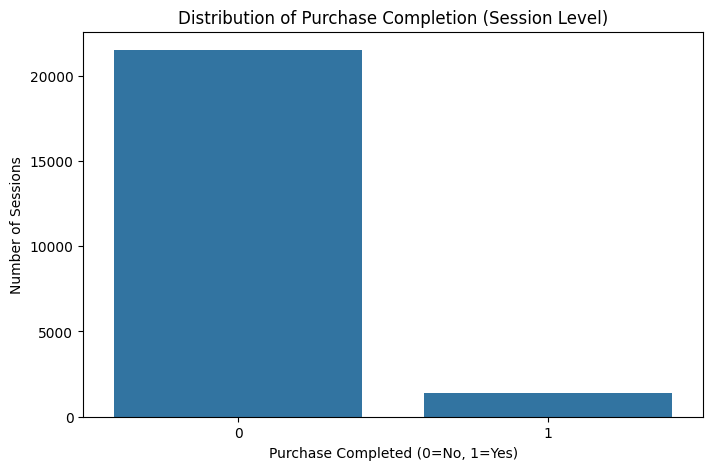

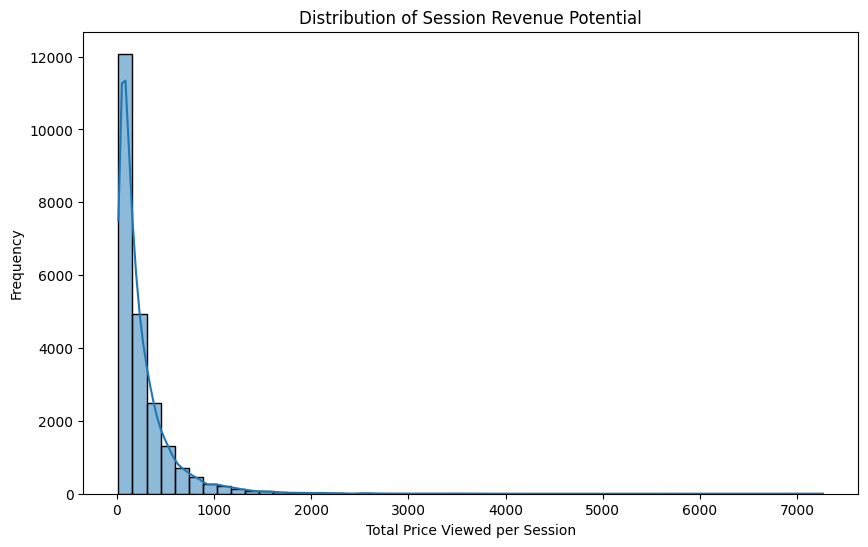

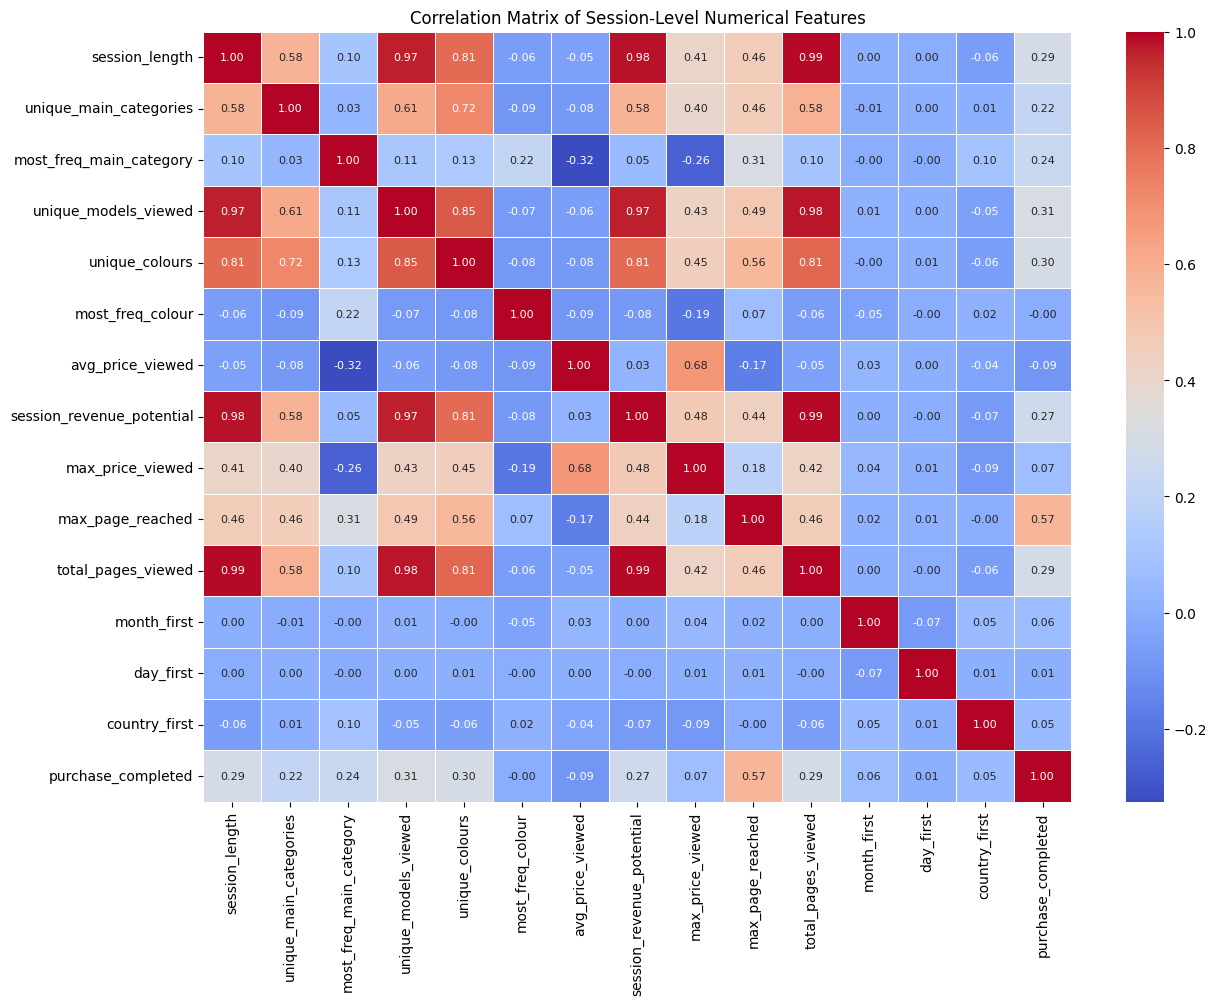

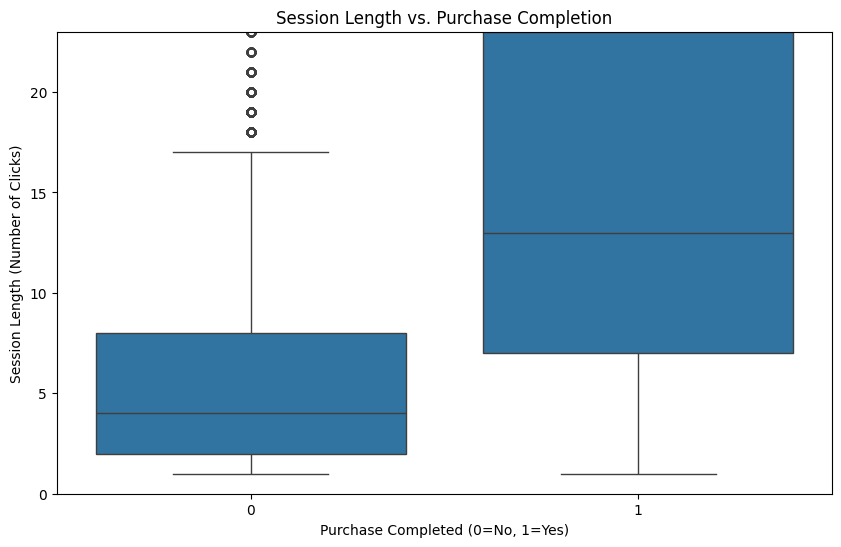

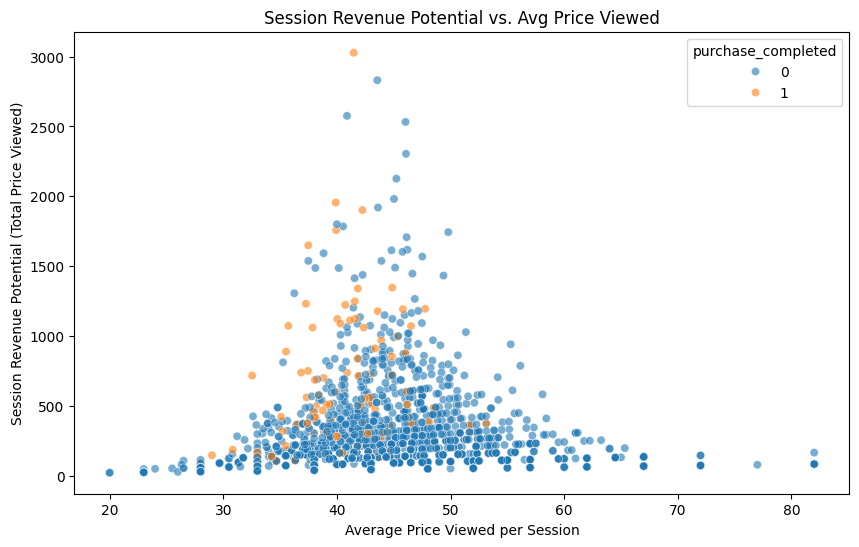

In [17]:
print("\n--- EDA on Session-Level Data ---")

# Analyze Classification Target distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='purchase_completed', data=df_session)
plt.title('Distribution of Purchase Completion (Session Level)')
plt.xlabel('Purchase Completed (0=No, 1=Yes)')
plt.ylabel('Number of Sessions')
purchase_counts = df_session['purchase_completed'].value_counts(normalize=True) * 100
print(f"\nPurchase Completion Distribution:\n{purchase_counts}")
plt.show()
# NOTE: Observe if this target is imbalanced!

# Analyze Regression Target distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_session['session_revenue_potential'], kde=True, bins=50)
plt.title('Distribution of Session Revenue Potential')
plt.xlabel('Total Price Viewed per Session')
plt.ylabel('Frequency')
plt.show()

# Correlation Heatmap for session-level numerical features
plt.figure(figsize=(14, 10))
# Select numerical columns (be careful with categorical ones like most_freq_...)
session_numerical_cols = df_session.select_dtypes(include=np.number).columns.tolist()
# Exclude identifiers if necessary, but keep targets to see correlations
# session_numerical_cols.remove('some_identifier_if_any')
correlation_matrix_session = df_session[session_numerical_cols].corr()
sns.heatmap(correlation_matrix_session, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8}) # Adjust font size if needed
plt.title('Correlation Matrix of Session-Level Numerical Features')
plt.show()
# Look for features strongly correlated with 'purchase_completed' and 'session_revenue_potential'

# Example Bivariate: Session Length vs Purchase Completed
plt.figure(figsize=(10, 6))
sns.boxplot(x='purchase_completed', y='session_length', data=df_session)
plt.title('Session Length vs. Purchase Completion')
plt.xlabel('Purchase Completed (0=No, 1=Yes)')
plt.ylabel('Session Length (Number of Clicks)')
plt.ylim(0, df_session['session_length'].quantile(0.95)) # Zoom in if outliers skew plot
plt.show()

# Example Bivariate: Avg Price Viewed vs Session Revenue Potential
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_price_viewed', y='session_revenue_potential', hue='purchase_completed', data=df_session.sample(min(2000, len(df_session))), alpha=0.6) # Sample for performance
plt.title('Session Revenue Potential vs. Avg Price Viewed')
plt.xlabel('Average Price Viewed per Session')
plt.ylabel('Session Revenue Potential (Total Price Viewed)')
plt.show()

In [18]:
# --- Add this to the end of 2_eda.ipynb ---
session_data_path = 'data_processed/session_data.csv'
try:
    df_session.to_csv(session_data_path, index=True) # Keep session_id as index for now
    print(f"\nSession-level data saved to: {session_data_path}")
except Exception as e:
    print(f"Error saving session data: {e}")
# --- End of addition ---


Session-level data saved to: data_processed/session_data.csv
